# Serial Handling

In [1]:
def SystemMessageCallback(serial, prnt_msg: bool = True, ret_hex_int: int = 0):
    """Reads the message buffer of a serial connection. Also prints out the general system message.
    serial      ... serial connection
    prnt_msg    ... print out the buffer
    ret_hex_int ... Parameters -> ['none','hex', 'int', 'both']
    
    @v=1.0.3
    """
    msg_dict = {
        "0x01": "No message inside the message buffer",
        "0x02": "Timeout: Communication-timeout (less data than expected)",
        "0x04": "Wake-Up Message: System boot ready",
        "0x11": "TCP-Socket: Valid TCP client-socket connection",
        "0x81": "Not-Acknowledge: Command has not been executed",
        "0x82": "Not-Acknowledge: Command could not be recognized",
        "0x83": "Command-Acknowledge: Command has been executed successfully",
        "0x84": "System-Ready Message: System is operational and ready to receive data",
        "0x91": "Data holdup: Measurement data could not be sent via the master interface",
    }
    timeout_count = 0
    received = []
    received_hex = []
    data_count = 0

    while True:
        buffer = serial.read()
        if buffer:
            received.extend(buffer)
            data_count += len(buffer)
            timeout_count = 0
            continue
        timeout_count += 1
        if timeout_count >= 1:
            # Break if we haven't received any data
            break

        received = "".join(str(received))  # If you need all the data
    received_hex = [hex(receive) for receive in received]
    try:
        msg_idx = received_hex.index("0x18")
        print(msg_dict[received_hex[msg_idx + 2]])
    except BaseException:
        print(msg_dict["0x01"])
        prnt_msg = False
    if prnt_msg:
        print("message buffer:\n", received_hex)
        print("message length:\t", data_count)

    if ret_hex_int == "none":
        return
    elif ret_hex_int == "hex":
        return received_hex
    elif ret_hex_int == "int":
        return received
    elif ret_hex_int == "both":
        return received, received_hex

In [2]:
import time

import numpy as np

from com_handling import available_serial_ports, connect_COM_port

In [3]:
available_serial_ports()

['COM1', 'COM3']

In [4]:
ser = connect_COM_port("COM3", timeout=1)

Connection to COM3 is established.


In [5]:
def GetFirmwareIDs(serial):
    """Get firmware IDs"""
    serial.write(bytearray([0xD2, 0x00, 0xD2]))
    SystemMessageCallback(serial)

In [6]:
GetFirmwareIDs(ser)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0xd2', '0x1e', '0x1', '0x11', '0x0', '0x19', '0x0', '0xb', '0x40', '0x0', '0x9', '0x0', '0x25', '0x2', '0xc9', '0x0', '0xf', '0x1', '0x11', '0x0', '0x19', '0x0', '0xb', '0x40', '0x0', '0x9', '0x0', '0x25', '0x2', '0xc9', '0x0', '0xf', '0xd2', '0x18', '0x1', '0x83', '0x18']
message length:	 37


In [7]:
from default_configurations import configuration_01

In [21]:
def StartStopMeasurement(serial):
    serial.write(bytearray([0xB4, 0x01, 0x01, 0xB4]))
    measurement_data_hex = SystemMessageCallback(
        serial, prnt_msg=False, ret_hex_int="hex"
    )
    print("Stopping measurement:")
    serial.write(bytearray([0xB4, 0x01, 0x00, 0xB4]))
    SystemMessageCallback(serial, prnt_msg=False, ret_hex_int="int")
    return measurement_data_hex


def StopMeasurement(serial):
    serial.write(bytearray([0xB4, 0x01, 0x00, 0xB4]))
    SystemMessageCallback(serial)

In [47]:
configuration_01(ser)
SystemMessageCallback(ser)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', '0x18', '0x18', '0x1', '0x83', 

In [85]:
# Write burst count
ser.write(bytearray([0xB0, 0x03, 0x02, 0x00, 0x01, 0xB0]))

6

In [87]:
SystemMessageCallback(ser)

No message inside the message buffer


In [88]:
measurement_data_hex = StartStopMeasurement(ser)

Command-Acknowledge: Command has been executed successfully
Stopping measurement:
Command-Acknowledge: Command has been executed successfully


In [89]:
len(measurement_data_hex)

17924

In [84]:
#np.save('hex_bc_200.npy', measurement_data_hex)

# Hexcallback

In [90]:
import struct
from dataclasses import dataclass
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np

In [91]:
#tmp = np.load("../test_messung_burstCnt_1.npz", allow_pickle=True)
#tmp.files

In [92]:
def del_hex_in_list(lst: list) -> list:
    return [
        "0" + ele.replace("0x", "") if len(ele) == 1 else ele.replace("0x", "")
        for ele in lst
    ]


def bytesarray_to_float(bytes_array: np.ndarray) -> float:
    bytes_array = [int(b, 16) for b in bytes_array]
    bytes_array = bytes(bytes_array)
    return struct.unpack("!f", bytes(bytes_array))[0]


def bytesarray_to_int(bytes_array: np.ndarray) -> int:
    bytes_array = bytesarray_to_byteslist(bytes_array)
    return int.from_bytes(bytes_array, "big")


def bytesarray_to_byteslist(bytes_array: np.ndarray) -> list:
    bytes_array = [int(b, 16) for b in bytes_array]
    return bytes(bytes_array)


def reshape_measurement_buffer(lst: list) -> np.ndarray:
    idx_b4 = [i for i, ele in enumerate(lst) if ele == "b4"]
    idx_b4 = np.array(idx_b4)
    step = abs(idx_b4[1] - idx_b4[0]) + 1
    return np.array(
        [lst[i : i + step] for i in range(idx_b4[0], idx_b4[-1] + step, step)],
        dtype=list,
    )[:-1]


@dataclass
class BaseSettingForEstimation:
    active_channel_groups: np.ndarray
    burst_count: int


@dataclass
class SingleFrame:
    start_tag: List[str]
    channel_group: str
    excitation_stgs: List[str]
    frequency_row: List[str]
    timestamp: int  # [ms]
    ch_1: complex
    ch_2: complex
    ch_3: complex
    ch_4: complex
    ch_5: complex
    ch_6: complex
    ch_7: complex
    ch_8: complex
    ch_9: complex
    ch_10: complex
    ch_11: complex
    ch_12: complex
    ch_13: complex
    ch_14: complex
    ch_15: complex
    ch_16: complex
    end_tag: str


def parse_single_frame(lst_ele: np.ndarray) -> SingleFrame:
    channels = {}
    enum = 0
    for i in range(11, 135, 8):
        enum += 1
        channels[f"ch_{enum}"] = complex(
            bytesarray_to_float(lst_ele[i : i + 4]),
            bytesarray_to_float(lst_ele[i + 4 : i + 8]),
        )

    excitation_stgs = np.array([ele for ele in lst_ele[3:5]])

    sgl_frm = SingleFrame(
        start_tag=lst_ele[0],
        channel_group=int(lst_ele[2]),
        excitation_stgs=excitation_stgs,
        frequency_row=lst_ele[5:7],
        timestamp=bytesarray_to_int(lst_ele[7:11]),
        **channels,
        end_tag=lst_ele[139],
    )
    return sgl_frm

In [94]:
# base_stgs_for_est = BaseSettingForEstimation(np.array([1]), 1)
# base_stgs_for_est

In [96]:
lst = del_hex_in_list(measurement_data_hex)#tmp["data_hex"]

In [97]:
l = reshape_measurement_buffer(lst)

In [99]:
def get_channel_group_img(reshaped_measurement_buffer: np.ndarray, channel_grout: int):
    img = np.empty((0,16))
    for i, sf in enumerate(reshaped_measurement_buffer):
        tmp_f = parse_single_frame(sf)
        if tmp_f.channel_group == channel_grout:
            tmp_f = tmp_f.__dict__
            tmp_row = np.array([tmp_f[f"ch_{ch_n}"] for ch_n in range(1, 17)])
            img = np.vstack((img, abs(tmp_row)))
    img = np.delete(np.matrix(img), 0, axis=0)
    print("Shape:", img.shape)
    return img

Shape: (31, 16)


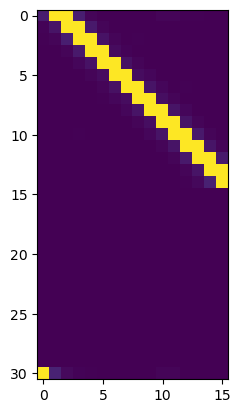

In [100]:
plt.imshow(get_channel_group_img(l, 1))